In [206]:
# lib:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import gensim.models
import gensim
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


In [207]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# part one 

In [208]:
# Load the dataset
df = pd.read_csv("Emotional-Tone-Dataset.csv")

In [209]:
df.head()

,ID,TWEET,LABEL
0,1,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,2,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,3,كتنا نيله ف حظنا الهباب xD,sadness
3,4,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,5,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10065 entries, 0 to 10064
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10065 non-null  int64 
 1    TWEET  10064 non-null  object
 2    LABEL  10065 non-null  object
dtypes: int64(1), object(2)
memory usage: 236.0+ KB


In [211]:
df[' LABEL'].value_counts()


 LABEL
none        1550
anger       1444
joy         1281
sadness     1256
love        1220
fear        1207
sympathy    1062
surprise    1045
Name: count, dtype: int64

In [212]:
df=df.drop('ID',axis=1)

In [213]:
df[' LABEL'].value_counts()

 LABEL
none        1550
anger       1444
joy         1281
sadness     1256
love        1220
fear        1207
sympathy    1062
surprise    1045
Name: count, dtype: int64

In [214]:
df = df[df[' LABEL'].str.lower() != 'none'].copy()

In [215]:
df[' LABEL'].value_counts()

 LABEL
anger       1444
joy         1281
sadness     1256
love        1220
fear        1207
sympathy    1062
surprise    1045
Name: count, dtype: int64

In [216]:
arabic_stopwords = set(stopwords.words("arabic"))

def clean_arabic(text):
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)  # remove non-Arabic
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)  # remove diacritics
    text = re.sub(r"@\w+|#\w+", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    text = re.sub(r'#', '', text)     # Remove hashtag symbol
    words = text.split()
    words = [w for w in words if w not in arabic_stopwords]
    return ' '.join(words)

df['cleaned_text'] = df[' TWEET'].astype(str).apply(clean_arabic)



In [217]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  # remove the extra words 
    return text

df['normalized_text'] = df['cleaned_text'].apply(normalize_arabic)
df['tokens'] = df['normalized_text'].apply(word_tokenize)


In [218]:
df.head()

,TWEET,LABEL,cleaned_text,normalized_text,tokens
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger,عجز الموازنه وصل الناتج المحلي يعني لسه اقل نف...,عجز الموازنه وصل الناتج المحلي يعني لسه اقل نف...,"[عجز, الموازنه, وصل, الناتج, المحلي, يعني, لسه..."
2,كتنا نيله ف حظنا الهباب xD,sadness,كتنا نيله حظنا الهباب,كتنا نيله حظنا الهباب,"[كتنا, نيله, حظنا, الهباب]"
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy,جميعنا نريد تحقيق اهدافنا تونس تالقت حراسه المرمي,جميعنا نريد تحقيق اهدافنا تونس تالقت حراسه المرمي,"[جميعنا, نريد, تحقيق, اهدافنا, تونس, تالقت, حر..."
5,دلوقتي عندها اربع سنين .... ومحدش يقدر يكلمها ...,surprise,دلوقتي عندها اربع سنين ومحدش يقدر يكلمها الله,دلوقتي عندها اربع سنين ومحدش يقدر يكلمها الله,"[دلوقتي, عندها, اربع, سنين, ومحدش, يقدر, يكلمه..."
6,الحب يسلبها كيدها يرجعها الي براءتها الاولي وي...,love,الحب يسلبها كيدها يرجعها الي براءتها الاولي وي...,الحب يسلبها كيدها يرجعها الي براءتها الاولي وي...,"[الحب, يسلبها, كيدها, يرجعها, الي, براءتها, ال..."


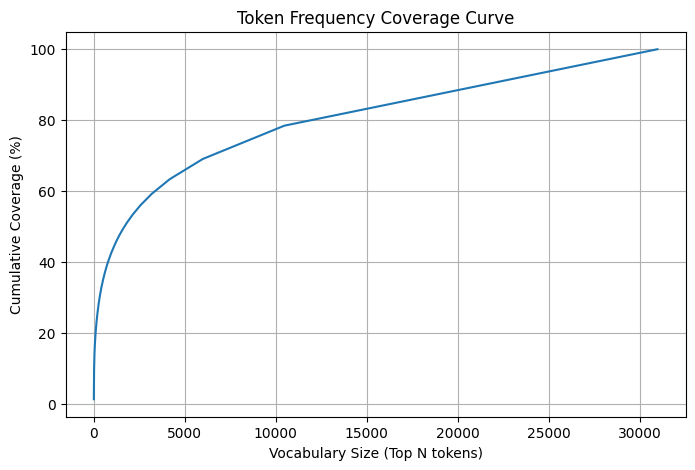

In [219]:
import matplotlib.pyplot as plt
from collections import Counter
all_tokens = [token for tokens in df['tokens'] for token in tokens]
token_counts = Counter(all_tokens)

# 2. Sort tokens by frequency
sorted_counts = np.array([count for token, count in token_counts.most_common()])
ranks = np.arange(1, len(sorted_counts) + 1)

# 3. Compute cumulative coverage
total_tokens = sorted_counts.sum()
cumulative_counts = np.cumsum(sorted_counts)
coverage = cumulative_counts / total_tokens * 100  # percentage

# 4. Create a DataFrame for inspection
coverage_df = pd.DataFrame({
    'rank': ranks,
    'coverage_percent': coverage
})


# 5. Plot the full cumulative coverage curve
plt.figure(figsize=(8, 5))
plt.plot(ranks, coverage)
plt.xlabel('Vocabulary Size (Top N tokens)')
plt.ylabel('Cumulative Coverage (%)')
plt.title('Token Frequency Coverage Curve')
plt.grid(True)
plt.show()

# part two

In [220]:
bow_vectorizer = CountVectorizer(max_features=25000)
X_bow = bow_vectorizer.fit_transform(df['normalized_text'])
y = df[' LABEL']


In [221]:
tfidf_vectorizer = TfidfVectorizer(max_features=25000)
X_tfidf = tfidf_vectorizer.fit_transform(df['normalized_text'])
y = df[' LABEL']



In [222]:
wv = KeyedVectors.load_word2vec_format('cc.ar.300.vec', binary=False)

def get_avg_vector(tokens):
    vectors = [wv[word] for word in tokens if word in wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

X_w2v = np.vstack(df['tokens'].apply(get_avg_vector).values)
y = df[' LABEL']


# part three

In [223]:
def run_grid(X, y, model_name, estimator, param_grid):
    """Fit GridSearchCV and print only best params + metrics on test set."""
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    pipe = Pipeline([
        ('scale', StandardScaler(with_mean=False)),  # with_mean=False for sparse data
        ('clf', estimator)
    ])
    grid = GridSearchCV(pipe, {'clf__' + k: v for k, v in param_grid.items()},
                        cv=3, n_jobs=-1, scoring='f1_macro')
    grid.fit(X_tr, y_tr)
    
    print(f"\n>>> {model_name}")
    print("Best params:", grid.best_params_)
    
    y_pred = grid.predict(X_te)
    print(classification_report(y_te, y_pred, digits=4))


In [224]:
# tf-idf
tfidf_grids = {
    'MultinomialNB': {
        'alpha': [0.1, 1.0, 5.0]
    },
    'SVM': {
        'kernel': ['rbf'],
        'C': [1, 10],
        'gamma': ['scale', 'auto']
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None]
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.5, 1.0]
    }
}

for name, grid_params in tfidf_grids.items():
    est = {
        'MultinomialNB': MultinomialNB(),
        'SVM': SVC(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'AdaBoost': AdaBoostClassifier()
    }[name]
    run_grid(X_tfidf, y, name, est, grid_params)


>>> MultinomialNB
Best params: {'clf__alpha': 5.0}
              precision    recall  f1-score   support

       anger     0.5240    0.5294    0.5267       289
        fear     0.5131    0.5685    0.5394       241
         joy     0.4545    0.4102    0.4312       256
        love     0.5785    0.5738    0.5761       244
     sadness     0.3839    0.3426    0.3621       251
    surprise     0.3170    0.3397    0.3279       209
    sympathy     0.6233    0.6526    0.6376       213

    accuracy                         0.4880      1703
   macro avg     0.4849    0.4881    0.4859      1703
weighted avg     0.4862    0.4880    0.4864      1703


>>> SVM
Best params: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

       anger     0.3772    0.5260    0.4393       289
        fear     0.7238    0.6307    0.6741       241
         joy     0.3440    0.5898    0.4345       256
        love     0.6855    0.4467    0.5409       244

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [225]:
# BoW
BoW_grids = {
    'MultinomialNB': {
        'alpha': [0.1, 1.0, 5.0]
    },
    'SVM': {
        'kernel': ['rbf'],
        'C': [1, 10],
        'gamma': ['scale', 'auto']
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 20]
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.5, 1.0]
    }
}

for name, grid_params in BoW_grids.items():
    est = {
        'MultinomialNB': MultinomialNB(),
        'SVM': SVC(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'AdaBoost': AdaBoostClassifier()
    }[name]
    run_grid(X_bow, y, name, est, grid_params)


>>> MultinomialNB
Best params: {'clf__alpha': 5.0}
              precision    recall  f1-score   support

       anger     0.5314    0.4983    0.5143       289
        fear     0.5182    0.5892    0.5515       241
         joy     0.4571    0.4375    0.4471       256
        love     0.5823    0.5656    0.5738       244
     sadness     0.4000    0.3665    0.3825       251
    surprise     0.3363    0.3589    0.3472       209
    sympathy     0.6502    0.6808    0.6651       213

    accuracy                         0.4979      1703
   macro avg     0.4965    0.4995    0.4974      1703
weighted avg     0.4972    0.4979    0.4969      1703


>>> SVM
Best params: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

       anger     0.4891    0.5433    0.5148       289
        fear     0.7143    0.7261    0.7202       241
         joy     0.3734    0.6797    0.4820       256
        love     0.6708    0.4426    0.5333       244

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [226]:
# w2v
w2v_grids = {
    'GaussianNB': {
        # GaussianNB has no hyperparams, but we include a dummy for pipeline naming
        'var_smoothing': [1e-9]
    },
    'SVM': {
        'kernel': ['rbf'],
        'C': [1, 10],
        'gamma': ['scale', 'auto']
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 20]
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.5, 1.0]
    }
}

for name, grid_params in w2v_grids.items():
    est = {
        'GaussianNB': GaussianNB(),
        'SVM': SVC(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'AdaBoost': AdaBoostClassifier()
    }[name]
    run_grid(X_w2v, y, name, est, grid_params)


>>> GaussianNB
Best params: {'clf__var_smoothing': 1e-09}
              precision    recall  f1-score   support

       anger     0.3966    0.7163    0.5105       289
        fear     0.7273    0.5975    0.6560       241
         joy     0.3846    0.2930    0.3326       256
        love     0.6194    0.6803    0.6484       244
     sadness     0.4177    0.1315    0.2000       251
    surprise     0.3962    0.3014    0.3424       209
    sympathy     0.5461    0.7230    0.6222       213

    accuracy                         0.4944      1703
   macro avg     0.4983    0.4919    0.4732      1703
weighted avg     0.4953    0.4944    0.4717      1703


>>> SVM
Best params: {'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

       anger     0.6677    0.7647    0.7129       289
        fear     0.8843    0.7925    0.8359       241
         joy     0.5799    0.6523    0.6140       256
        love     0.7534    0.6885    0.7195    

# part four 

In [227]:
# tfidf
# Encode target labels
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_tfidf.toarray(), y_encoded, test_size=0.2)

model = Sequential([
    Dense(64, input_shape=(X_train_nn.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5), # we put dropout becuase it was overfiiting 
    Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_nn, y_train_nn, epochs=10, validation_data=(X_test_nn, y_test_nn))


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.2007 - loss: 1.9288 - val_accuracy: 0.5619 - val_loss: 1.6923
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4552 - loss: 1.5545 - val_accuracy: 0.6254 - val_loss: 1.2257
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6250 - loss: 1.0817 - val_accuracy: 0.6688 - val_loss: 1.0324
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7518 - loss: 0.7356 - val_accuracy: 0.6747 - val_loss: 0.9701
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8427 - loss: 0.5140 - val_accuracy: 0.6718 - val_loss: 0.9883
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9029 - loss: 0.3595 - val_accuracy: 0.6682 - val_loss: 1.0244
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9214 - loss: 0.2847 - val_accuracy: 0.6606 - val_loss: 1.0785
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9352 - loss: 0.2347 - val_accu

In [228]:
# W2V

# Encode target labels
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))
scaler = StandardScaler()
X_w2v = scaler.fit_transform(X_w2v)
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_w2v, y_encoded, test_size=0.2)

model = Sequential([
    Dense(256, input_shape=(X_train_nn.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3), # we put dropout to prevent overfitting 
    Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_nn, y_train_nn, epochs=10, validation_data=(X_test_nn, y_test_nn))


Epoch 1/10


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4279 - loss: 1.5992 - val_accuracy: 0.6136 - val_loss: 1.0510
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6507 - loss: 0.9974 - val_accuracy: 0.6418 - val_loss: 0.9905
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6768 - loss: 0.9133 - val_accuracy: 0.6512 - val_loss: 0.9661
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7139 - loss: 0.8092 - val_accuracy: 0.6430 - val_loss: 0.9786
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7377 - loss: 0.7280 - val_accuracy: 0.6494 - val_loss: 0.9846
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7482 - loss: 0.7090 - val_accuracy: 0.6659 - val_loss: 0.9782
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7733 - loss: 0.6312 - val_accuracy: 0.6606 - val_loss: 0.9939
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7795 - loss: 0.5944 - val_accuracy: 0.6606 - val_

# part five

In [229]:
df = pd.read_csv("Emotional-Tone-Dataset.csv")
X_text = df[' TWEET']
y = df[' LABEL']
vocab_size = 25000
max_len = 100
X_text = X_text.astype(str)  # Converts all entries to string
X_text = X_text.fillna('')   # Replace any NaNs with empty strings
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))
w2v = gensim.models.KeyedVectors.load_word2vec_format("cc.ar.300.vec", binary=False)
embedding_dim = w2v.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < vocab_size and word in w2v:
        embedding_matrix[i] = w2v[word]
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, stratify=y)
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))  # keep Word2Vec fixed
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu')) 
model.add(Dense(y_encoded.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.3263 - loss: 1.8082 - val_accuracy: 0.5728 - val_loss: 1.2751
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.5727 - loss: 1.2369 - val_accuracy: 0.6185 - val_loss: 1.1149
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 46s 175ms/step - accuracy: 0.6325 - loss: 1.0610 - val_accuracy: 0.6080 - val_loss: 1.1332
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.6591 - loss: 0.9983 - val_accuracy: 0.6314 - val_loss: 1.0461
Epoch 5/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.6702 - loss: 0.9570 - val_accuracy: 0.6393 - val_loss: 1.0471
Epoch 6/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.6913 - loss: 0.8971 - val_accuracy: 0.6498 - val_loss: 1.0298
Epoch 7/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.7097 - loss: 0.8409 - val_accuracy: 0.6528 - val_loss: 1.0267
Epoch 8/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 70s 277ms/step - accuracy: 0.7173 - loss: 0